In [1]:
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import imageio
import pickle

# Useful functions

## Function to build the data frames

In [2]:
def build_dataframe(path):
    with open(path) as f:
        lines = f.readlines()
    mice_dict = {}
    table = []
    times = []
    for l in lines[4:]:
        values = l.strip().split(',')
        time = eval(values.pop(0))
        times.append(time)
        # values = [eval(v) if v!='' else -1 for v in values]
        values = [eval(v) if v!='' else np.nan for v in values]
        table.append(values)
    table = np.array(table)
    for i, (mouse, body) in enumerate(zip(lines[1].strip().split(',')[1:],
                                          lines[2].strip().split(',')[1:])):
        if i%3==0:
            val = 'x'
        elif i%3==1:
            val = 'y'
        else:
            val = 'likelyhood'
        mice_dict[mouse, body, val] = table[:, i]
        df = pd.DataFrame(mice_dict)        
        sel_names = df.columns.levels[0]
        n_mus = len(sel_names)
        d = dict(zip(sel_names, ['mus'+str(i+1) for i in range(n_mus)]))
        df.rename(columns=d, level=0, inplace=True)


        
    return np.array(times), df

## Function to find rotarod boudaries

In [3]:
def find_sep(vid,frame=1,rotatype = 'black', verbose=False):
    """ function used to find the separator between mices
    
    Args:
        vid (imageio reader): video of mices
        frame (int): frame number used to find the separator

    Returns:
        list: list of separator
    """
    image = vid.get_data(frame)
    ylen = len(image) # size of the image

    
    if rotatype == 'black':
        lim_range = range(int(ylen/4)) # part of the image used to compute the threshold
    else:
        lim_range = range(int(ylen/3),int(3/4*ylen))
        

    line = np.sum(image[lim_range,::], axis=(0,2))
    
    if rotatype == 'black':
        limit = np.mean(line) # value used as a threshold
    else:
        line = np.max(line) - np.array(line)
        limit = np.percentile(line, 8) # value used as a threshold
                     

    if verbose:
        plt.axhline(limit, color='k')
        plt.plot(line)
    
   
    not_in_separator = True
    border = []  # list which contain the two border of each separator
    for i in range(len(line)):
        if line[i] < limit and not_in_separator: # if the value is less than the threshold and not. in a sep, it's a left border
            not_in_separator = False
            border.append(i)
        if not not_in_separator and line[i] > limit: # if the value is more than the threshold on in a sep, it's a right border
            not_in_separator = True
            border.append(i)
    # just if the last value is under the threshold, add it as a border (the right border is not in the picture)
    if line[-1] < limit: 
        border.append(i)
        
    limit_border = []
    # print("there is {} sep".format(len(border)/2))
    for i in range(0,len(border),2):
        if i< len(border)/2:
            limit_border.append(border[i])
        else:
            limit_border.append(border[i+1])
            
    if (rotatype == 'white') & (len(limit_border) > 5):
        # empirical remove of non correct border for white rotarod
        limit_border.pop(-2)

    
    if verbose:
        for sep in limit_border:
            plt.axvline(sep,color="red")
            
            
    return limit_border

## Functions to clean the data

In [4]:
def define_x_range(sep_dict, group, trial,rotatype= 'black',shift=1):
    
    sep = sep_dict[('G' + str(group), 'Trial' + str(trial))]
    x_range = [[sep[i]+shift,sep[i+1]-shift] for i in range(len(sep)-1)]
        
    if (rotatype == 'black') & (len(x_range) == 5):
        x_range.pop(2)
    
    return x_range

In [5]:
def assign_according_x(df, x_range):
    sel_names = df.columns.levels[0].tolist()
    bodyparts = df.columns.levels[1].tolist()
    coords = df.columns.levels[2].tolist()
    df_copy = pd.DataFrame().reindex_like(df)
    for bp in bodyparts: 
        for i, vals in enumerate(x_range):
            for name in sel_names:
                mask = (df[name, bp, 'x']>vals[0]) & (df[name, bp, 'x']<vals[1]) 
                for coord in coords:
                    df_copy['mus'+str(i+1), bp, coord][mask] = df[name, bp, coord][mask]    
      
    if 'mus5' in sel_names:            
        df_copy = df_copy.drop('mus5', axis=1, level=0)
    df_copy.columns = df_copy.columns.remove_unused_levels()
    return df_copy

In [6]:
def remove_outliers_and_interpolate(df, interpolate=False):
    framerate = 30
    sel_names = df.columns.levels[0].tolist()
    bodyparts = df.columns.levels[1].tolist()

    df = df.mask(df.sub(df.mean()).div(df.std()).abs().gt(2))
        
    if interpolate:
        for bp in bodyparts:
            for name in sel_names:
                df[name, bp, 'x'].interpolate(interpolate='time', limit_area='inside', limit=int(.5*framerate), inplace=True)
                df[name, bp, 'y'].interpolate(interpolate='time', limit_area = 'inside', limit=int(.5*framerate), inplace=True)    
    return df

## Functions to make plots

In [7]:
def plot_relavant_bps(df,times,fig_name):
    sel_bps = ['bodycentre','tailbase',
               'lefthindlimb','righthindlimb']
    frame_rate = 30
    t_length = times.shape[0]
    time_in_sec = t_length / frame_rate
    time = np.linspace(0,time_in_sec,t_length)
    
    fig, axs = plt.subplots(2,2, figsize=(15,6))
    for i, ax in enumerate(axs.flat):
        bp = sel_bps[i]
        ax.plot(time, df[bp,'x'].iloc[:t_length])
        ax.plot(time, df[bp,'y'].iloc[:t_length])
        ax.set_title(bp)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0,time_in_sec)
    fig.tight_layout()
    fig.savefig(fig_name,format="pdf", bbox_inches="tight")    

In [8]:
def plot_line_on_img(sep,vid,frame=10):
    """function used to plot the separators on the image
    
    Args:
        sep (list): list of x positions of the separators
        vid (imageio reader): video used 
        frame (int): frame number for the display

    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(vid.get_data(frame), )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for x in sep:
        plt.axvline(x,linewidth=6)
        plt.axvline(x+5,color="yellow")
        plt.axvline(x-5,color="yellow")

    fig.tight_layout()

# Create directories for the results

In [13]:
main_dir = '/home/stef/projects/rotariu_zalcman_2025'

videos_dir = main_dir + '/data-all/videos/'
data_dir = main_dir + '/data-all/files_csv/'

pickle_dir = main_dir + '/results/pickle/'
plots_dir = main_dir + '/results/plots/'

Path(pickle_dir).mkdir(parents=True, exist_ok=True)
Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Find boundaries

In [14]:
n_groups = 5 
n_days = 5
n_trials = 10 * n_days 

In [15]:
sep_dict = {}
suffix = '.avi'
fr_num = 100

for group in range(1,n_groups+1):
        
    if group < 3:
        rotatype = 'black'
    else:
        rotatype = 'white'
        
    for trial in range(1,n_trials+1):
        video_name = '/Group' + str(group) + '_Trial' + str(trial) + suffix
        path = Path(videos_dir + video_name)
        print('G{:d}, trial{:d}'.format(group,trial))
        if (path.is_file()):
        # video = videos_dir + video_name 
            vid = imageio.get_reader(path)
            sep = find_sep(vid,frame=fr_num,rotatype = rotatype)
            sep_dict[('G' + str(group), 'Trial' + str(trial))] = sep    
            if len(sep) > 6:
                print("WARNING: too many borders")
        else:
            sep_dict[('G' + str(group), 'Trial' + str(trial))] = []
            print(path.name + " is missing !\n")

G1, trial1
G1, trial2
G1, trial3
G1, trial4
G1, trial5
G1, trial6
G1, trial7
G1, trial8
G1, trial9
G1, trial10
G1, trial11
G1, trial12
G1, trial13
G1, trial14
G1, trial15
G1, trial16
G1, trial17
G1, trial18
G1, trial19
G1, trial20
G1, trial21
G1, trial22
G1, trial23
G1, trial24
G1, trial25
G1, trial26
G1, trial27
G1, trial28
G1, trial29
G1, trial30
G1, trial31
G1, trial32
G1, trial33
G1, trial34
G1, trial35
G1, trial36
G1, trial37
G1, trial38
G1, trial39
G1, trial40
G1, trial41
G1, trial42
G1, trial43
Group1_Trial43.avi is missing !

G1, trial44
G1, trial45
G1, trial46
G1, trial47
G1, trial48
G1, trial49
G1, trial50
G2, trial1
G2, trial2
G2, trial3
G2, trial4
G2, trial5
G2, trial6
G2, trial7
G2, trial8
G2, trial9
G2, trial10
G2, trial11
G2, trial12
G2, trial13
G2, trial14
Group2_Trial14.avi is missing !

G2, trial15
G2, trial16
G2, trial17
G2, trial18
G2, trial19
G2, trial20
G2, trial21
G2, trial22
G2, trial23
G2, trial24
G2, trial25
G2, trial26
G2, trial27
G2, trial28
G2, trial29
G2, 

G3, trial4


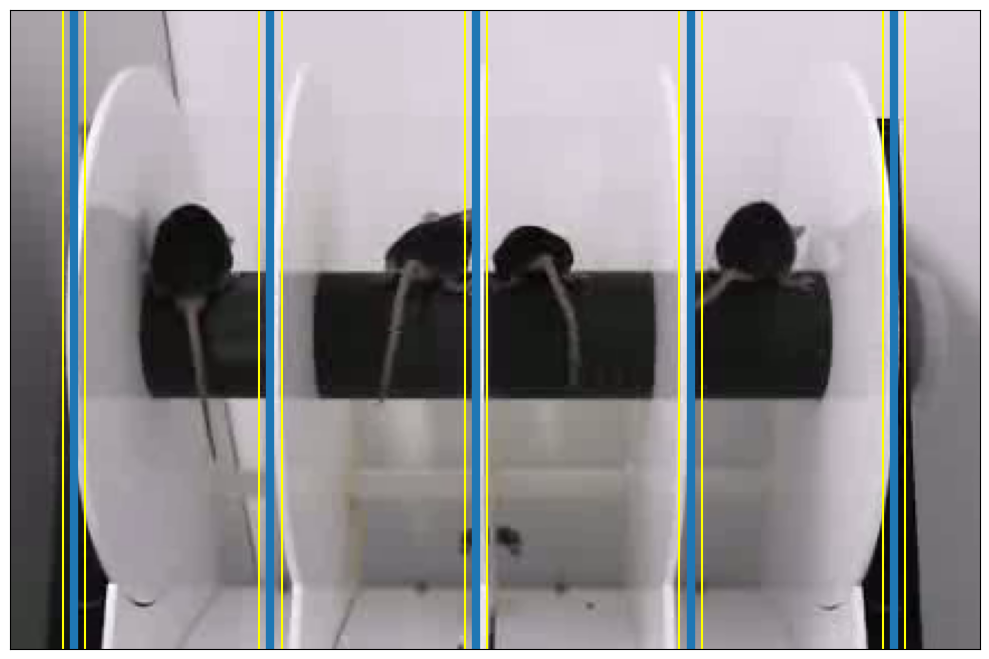

In [16]:
sep_dict_sel = {}
suffix = '.avi'

group = 3
trial = 4 
if group < 3:
    rotatype = 'black'
    fr_num = 10
else:
    rotatype = 'white'
    fr_num = 100
    
video_name = '/Group' + str(group) + '_Trial' + str(trial) + suffix
path = Path(videos_dir + video_name)
print('G{:d}, trial{:d}'.format(group,trial))
if (path.is_file()):
# video = videos_dir + video_name 
    vid = imageio.get_reader(path)
    sep = find_sep(vid,frame=fr_num,rotatype = rotatype)
    sep_dict_sel[('G' + str(group), 'Trial' + str(trial))] = sep
    plot_line_on_img(sep,vid,frame=fr_num)
else:
    sep_dict_sel[('G' + str(group), 'Trial' + str(trial))] = []
    print(path.name + " is missing !\n")

# Clean the data and build a dataframe for each mouse

In [17]:
# parts = ['leftEar', 'bodycentre', 'lefthindlimb', 'tailbase','rightEar', 'nose',  'righthindlimb', 'tailtip']
# days = ["Day1", "Day2", "Day3", "Day4", "Day5"]
# trials = ["Trial1", "Trial2", "Trial3", "Trial4", "Trial5", "Trial6", "Trial7", "Trial8", "Trial9", "Trial10"]
# paired = list(itertools.product(days, trials))
tr_names = ["Trial" + str(i) for i in range(1,n_trials+1)]

In [18]:
suffix = '.csv'
results_dir = pickle_dir

for group in range(1,n_groups+1):
# for group in range(3,4):

    file_to_save =  pickle_dir + 'results_group' + str(group) + '.pickle'
    
    if group < 3:
        rotatype = 'black'
    else:
        rotatype = 'white'
    
    times_dict = {}
    mouse1 = []
    mouse2 = []
    mouse3 = []
    mouse4 = []
    for trial in range(1,n_trials+1):
        print('Processing group {:d}, trial {:d}'.format(group,trial))

        filename = '/Group' + str(group) + '_Trial' + str(trial) + suffix
        data_path = Path(data_dir + filename)
        x_range = define_x_range(sep_dict, group, trial, rotatype)
        if not(x_range):
            print(data_path.name + ' the corresponding .avi is missing \nUsing borders from prevoius trial')    
            x_range = define_x_range(sep_dict, group, trial, rotatype)

        if (data_path.is_file()):
            times, df = build_dataframe(data_path)
            df = assign_according_x(df, x_range)
            df_clean = remove_outliers_and_interpolate(df)
            times_dict['Trial'+str(trial)] = times
        else:
            print(data_path.name + ' is missing')
            df = df.iloc[0:0]
            df_clean = df
            times_dict['Trial'+str(trial)] = []


        mouse1.append(df_clean['mus1'])
        mouse2.append(df_clean['mus2'])
        mouse3.append(df_clean['mus3'])
        mouse4.append(df_clean['mus4'])                    
        
    mus1_df = pd.concat(mouse1, keys = tr_names, axis=1)
    mus2_df = pd.concat(mouse2, keys = tr_names, axis=1)
    mus3_df = pd.concat(mouse3, keys = tr_names, axis=1)
    mus4_df = pd.concat(mouse4, keys = tr_names, axis=1)  
    
    if rotatype == 'white': # in theory this is not necessary, df.rename ignores the errors
        cols_rename ={"bodycenter": "bodycentre", "leftlimb": "lefthindlimb","rightlimb": "righthindlimb"}
        mus1_df.rename(columns=cols_rename, inplace=True)
        mus2_df.rename(columns=cols_rename, inplace=True)
        mus3_df.rename(columns=cols_rename, inplace=True)
        mus4_df.rename(columns=cols_rename, inplace=True)

    results = {}
    for i in ('mus1_df', 'mus2_df', 
              'mus3_df', 'mus4_df', 
              'times_dict'):
        results[i] = locals()[i]
    
    with open(file_to_save, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)  

Processing group 1, trial 1
Processing group 1, trial 2
Processing group 1, trial 3
Processing group 1, trial 4
Processing group 1, trial 5
Processing group 1, trial 6
Processing group 1, trial 7
Processing group 1, trial 8
Processing group 1, trial 9
Processing group 1, trial 10
Processing group 1, trial 11
Processing group 1, trial 12
Processing group 1, trial 13
Processing group 1, trial 14
Processing group 1, trial 15
Processing group 1, trial 16
Processing group 1, trial 17
Processing group 1, trial 18
Processing group 1, trial 19
Processing group 1, trial 20
Processing group 1, trial 21
Processing group 1, trial 22
Processing group 1, trial 23
Processing group 1, trial 24
Processing group 1, trial 25
Processing group 1, trial 26
Processing group 1, trial 27
Processing group 1, trial 28
Processing group 1, trial 29
Processing group 1, trial 30
Processing group 1, trial 31
Processing group 1, trial 32
Processing group 1, trial 33
Processing group 1, trial 34
Processing group 1, tri